**TO DO**

- [ ] which params to optimize, read from config according to algo type

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import os

In [70]:
from utils.pipeline import run_matches_discovery, discovery_pipeline
from utils.pipeline_wrappers import gen_expname, run_until_coverage_th, try_run_exp, cv_experiment, monitor_callback, grid_exp
from utils.feature_utils import op_100, get_feats, get_seq_names, get_dh_feats_wrap, load_feats

In [71]:
from utils.helper_fncs import load_json, save_json


In [72]:
alg_type = 'knn'
params = load_json(full_path='/home/korhan/Dropbox/config/{}.json'.format(alg_type))
params

{'CVroot': '/home/korhan/Dropbox/CVfolds',
 'CVset': 'A',
 'clustering': {'cost_thr': 0.01, 'method': 'pairwise', 'olapthr_m': 0.25},
 'config_file': '/home/korhan/Dropbox/config/config_phoenix.json',
 'covth': 0.1,
 'dataset': 'phoenix',
 'disc': {'a': 4,
  'dim_fix': 10,
  'emb_type': 'gauss_kernel',
  'k': 100,
  'lmax': 28,
  'lmin': 4,
  'metric': 'L2',
  'norm': False,
  'olapthr_m': 0.25,
  'pca': '',
  'r': 0.2,
  's': 0.2,
  'seg_type': 'uniform',
  'top_delta': 0.02,
  'use_gpu': True},
 'disc_method': 'knn',
 'exp_root': '/home/korhan/Desktop/tez/knn_exps/',
 'feats_root': '/home/korhan/Desktop/tez/dataset/features/',
 'featype': 'c3right',
 'lr': 0.8,
 'njobs': 2,
 'patience': 30,
 'tune': {'keys': ['r', 's'],
  'minimizer': 'gp',
  'n_split': 1,
  'stop_margin': 0.01,
  'stopper_patience': 5}}

In [73]:
params['tune'] = {'keys': ['r', 's'],
  'minimizer': 'gp',
  'n_split': 1,
  'stop_margin': 0.01,
  'stopper_patience': 5}

In [74]:
params

{'CVroot': '/home/korhan/Dropbox/CVfolds',
 'CVset': 'A',
 'clustering': {'cost_thr': 0.01, 'method': 'pairwise', 'olapthr_m': 0.25},
 'config_file': '/home/korhan/Dropbox/config/config_phoenix.json',
 'covth': 0.1,
 'dataset': 'phoenix',
 'disc': {'a': 4,
  'dim_fix': 10,
  'emb_type': 'gauss_kernel',
  'k': 100,
  'lmax': 28,
  'lmin': 4,
  'metric': 'L2',
  'norm': False,
  'olapthr_m': 0.25,
  'pca': '',
  'r': 0.2,
  's': 0.2,
  'seg_type': 'uniform',
  'top_delta': 0.02,
  'use_gpu': True},
 'disc_method': 'knn',
 'exp_root': '/home/korhan/Desktop/tez/knn_exps/',
 'feats_root': '/home/korhan/Desktop/tez/dataset/features/',
 'featype': 'c3right',
 'lr': 0.8,
 'njobs': 2,
 'patience': 30,
 'tune': {'keys': ['r', 's'],
  'minimizer': 'gp',
  'n_split': 1,
  'stop_margin': 0.01,
  'stopper_patience': 5}}

In [66]:
alg_type

'knn'

In [69]:
save_json(full_path='/home/korhan/Dropbox/config/{}'.format(alg_type), data=params)

In [21]:
# params['disc']['B'] = 150
# params['clustering']['cost_thr'] = 0.001

In [22]:
params['CVset'] = 'A'
seq_names = get_seq_names(params)


In [23]:
len(seq_names), params['CVset']

(1705, 'A')

In [24]:
# params['featype'] = 'op100_medfilt'
params['featype'] = 'c3_right'
feats_dict = load_feats(seq_names, params['featype'], params)
feats_dict[seq_names[0]].shape

(151, 61)

In [10]:
import numpy as np
import time
import skopt
from skopt import gp_minimize, space, forest_minimize, dummy_minimize, gbrt_minimize
from skopt.plots import plot_convergence, plot_evaluations, plot_objective, plot_regret, partial_dependence
from functools import partial
from skopt import gp_minimize, forest_minimize, dummy_minimize
from skopt.callbacks import TimerCallback, CheckpointSaver, DeltaYStopper, VerboseCallback
from functools import partial

In [11]:

SPACE_ZR = [
           skopt.space.Real(0.2, 0.7, name='T', prior='uniform'),
           skopt.space.Real(0.2, 0.7, name='medthr', prior='uniform'),
           skopt.space.Integer(3, 30, name='dx',prior='uniform'),
           skopt.space.Real(0.5, 30.0, name='castthr',prior='uniform'),
        ]

SPACE_KNN = [ 
#            skopt.space.Integer(20, 200, name='k', prior='uniform'),
#            skopt.space.Real(0.001, 0.5, name='top_delta', prior='uniform'),
           skopt.space.Real(0.0, 1.5, name='r',prior='uniform'),
           skopt.space.Real(0.0, 1.5, name='s',prior='uniform'),
           skopt.space.Categorical(['','PCA40','PCAW40'], name='pca'),
           skopt.space.Categorical([True,False], name='norm'),            
        ]

space_select = {'zr': SPACE_ZR, 'zr_cat': SPACE_ZR, 'knn': SPACE_KNN}

SPACE = space_select[params['disc_method']]

keys = [key.name for key in SPACE]
x0 = [params['disc'][k] for k in keys]

SPACE, x0

([Real(low=0.0, high=1.5, prior='uniform', transform='identity'),
  Real(low=0.0, high=1.5, prior='uniform', transform='identity'),
  Categorical(categories=('', 'PCA40', 'PCAW40'), prior=None),
  Categorical(categories=(True, False), prior=None)],
 [0.2, 0.2, 'PCA40', False])

In [12]:
SPACE

[Real(low=0.0, high=1.5, prior='uniform', transform='identity'),
 Real(low=0.0, high=1.5, prior='uniform', transform='identity'),
 Categorical(categories=('', 'PCA40', 'PCAW40'), prior=None),
 Categorical(categories=(True, False), prior=None)]

In [12]:
params['disc']['top_delta'] = 0.01


In [13]:
@skopt.utils.use_named_args(SPACE)
def objective(**space_params):
    
    params['disc'] = {**params['disc'], **space_params}

    tstart = time.time()
#     scores = cv_experiment(seq_names, feats_dict, params)
    scores = try_run_exp(feats_dict, params, genname=True)
    
    telapsed = time.time() - tstart
    print(' === Experiment completed in {}m {:.1f}seconds ==='.format(
                                   telapsed//60, telapsed%60 ))
    
    if not isinstance(scores, dict): 
        return 1.
    else:
        return scores['ned']

In [14]:
def run(minimizer, name, n_iter=3):
    checkpoint_saver = CheckpointSaver("../../Desktop/tez/checkpoints/knn/{}_c3right.pkl".format(name), compress=9)
    stopper = DeltaYStopper(0.02, 6)
    timer = TimerCallback()
    
    return [minimizer(objective, SPACE, n_calls=20, x0=x0, random_state=9, 
                      callback=[checkpoint_saver, stopper, timer])
            for n in range(n_iter)]


# # Random search
# dummy_res = run(partial(dummy_minimize), 'dummy')

# Gaussian processes
# gp_res = run(partial(gp_minimize, x0=x0, y0=y0), 'gp')
# gp_res = run(partial(gp_minimize, n_random_starts=3), 'gp')

# Random forest
# rf_res = run(partial(forest_minimize, n_random_starts=3, base_estimator="RF"), 'rf')

# # Extra trees
# et_res = run(partial(forest_minimize, base_estimator="ET"))

# gradient boosted trees
gbrt_res = run(partial(gbrt_minimize, n_random_starts=3), 'gbrt3')
# gbrt_res = run(partial(gbrt_minimize, x0=x0, y0=y0, ), 'gbrt3')



knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k100_lmax28_lmin4_metricL2_olapthr_m0.25_pcaPCA40_r0.2_s0.2_seg_typeuniform_normFalse_top_delta0.01_use_gpuTrue
0.01
*** Matches already discovered !!! ***
*** found 22851 matches ***
*** post disc completed, found 458 segments from 229 clusters ***
*** Coverage: 0.0049, NED: 0.33
trial 0 th:0.01000 cov:0.00490 err:-0.09510
0.163265306122449
*** Matches already discovered !!! ***
*** found 22851 matches ***
*** post disc completed, found 5950 segments from 2975 clusters ***
*** Coverage: 0.0661, NED: 0.53
trial 1 th:0.16327 cov:0.06610 err:-0.03390
0.20052981192476993
*** Matches already discovered !!! ***
*** found 22851 matches ***
*** post disc completed, found 7110 segments from 3555 clusters ***
*** Coverage: 0.0793, NED: 0.54
trial 2 th:0.20053 cov:0.07930 err:-0.02070
0.23982692713449025
*** Matches already discovered !!! ***
*** found 22851 matches ***
*** post disc completed, found 8332 segments from 4166 clusters ***
*** Covera

KeyboardInterrupt: 

In [54]:
rf_res

[          fun: 0.4804
     func_vals: array([0.5524, 1.    , 0.6414, 0.4804, 0.6316, 0.6461, 0.492 , 0.5787,
        1.    , 0.4889])
        models: [RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=3,
                       min_samples_split=2, min_variance=0.0,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=209652396, verbose=0,
                       warm_start=False), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=3,
                       min_samples_split=2, min_variance=0.0,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=

In [14]:
name = '{}/gp_c3right'.format(params['disc_method'])
checkpoint_saver = CheckpointSaver("../../Desktop/tez/checkpoints/{}.pkl".format(name), compress=9)
stopper = DeltaYStopper(0.01, 5)
timer = TimerCallback()

res = gp_minimize(objective, SPACE, n_calls=30, x0=x0, random_state=1, n_random_starts=5,
                  callback=[checkpoint_saver, stopper, timer])

knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k100_lmax28_lmin4_metricL2_olapthr_m0.25_pcaPCA40_r0.2_s0.2_seg_typeuniform_normFalse_top_delta0.02_use_gpuTrue
0.01
Building index of size 386876x610
*** found 75305 matches ***
*** pairwise clustering ***
*** post disc completed, found 1486 segments from 743 clusters ***
*** Coverage: 0.0129, NED: 0.49
trial 0 th:0.01000 cov:0.01290 err:-0.08710
0.062015503875969
*** Matches already discovered !!! ***
*** found 75305 matches ***
*** pairwise clustering ***
*** post disc completed, found 7124 segments from 3562 clusters ***
*** Coverage: 0.0762, NED: 0.55
trial 1 th:0.06202 cov:0.07620 err:-0.02380
0.06725814075951848
*** Matches already discovered !!! ***
*** found 75305 matches ***
*** pairwise clustering ***
*** post disc completed, found 7606 segments from 3803 clusters ***
*** Coverage: 0.0810, NED: 0.54
trial 2 th:0.06726 cov:0.08100 err:-0.01900
0.08281129684738196
*** Matches already discovered !!! ***
*** found 75305 matches **

*** post disc completed, found 15250 segments from 7625 clusters ***
*** Coverage: 0.0389, NED: 0.31
trial 1 th:0.14815 cov:0.03890 err:-0.06110
0.32209110005527924
*** Matches already discovered !!! ***
*** found 74226 matches ***
*** pairwise clustering ***
*** post disc completed, found 33850 segments from 16925 clusters ***
*** Coverage: 0.0644, NED: 0.34
trial 2 th:0.32209 cov:0.06440 err:-0.03560
0.48157291243130773
*** Matches already discovered !!! ***
*** found 74226 matches ***
*** pairwise clustering ***
*** post disc completed, found 52954 segments from 26477 clusters ***
*** Coverage: 0.0864, NED: 0.36
trial 3 th:0.48157 cov:0.08640 err:-0.01360
0.528547555349338
*** Matches already discovered !!! ***
*** found 74226 matches ***
*** pairwise clustering ***
*** post disc completed, found 58826 segments from 29413 clusters ***
*** Coverage: 0.0928, NED: 0.37
trial 4 th:0.52855 cov:0.09280 err:-0.00720
 === Experiment completed in 4.0m 6.7seconds ===
knn_A_c3_right_a4_dim_fix

/home/korhan/miniconda3/envs/tez/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k100_lmax28_lmin4_metricL2_olapthr_m0.25_pca_r0.01_s0.01_seg_typeuniform_normTrue_top_delta0.005_use_gpuTrue
0.01
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 1360 segments from 680 clusters ***
*** Coverage: 0.0047, NED: 0.25
trial 0 th:0.01000 cov:0.00470 err:-0.09530
0.1702127659574468
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 18016 segments from 9008 clusters ***
*** Coverage: 0.0254, NED: 0.25
trial 1 th:0.17021 cov:0.02540 err:-0.07460
0.6000783225408574
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 73796 segments from 36898 clusters ***
*** Coverage: 0.0769, NED: 0.29
trial 2 th:0.60008 cov:0.07690 err:-0.02310
0.6683559973535234
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 83678 segments from 41839 clusters ***
*** Cove

/home/korhan/miniconda3/envs/tez/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k100_lmax28_lmin4_metricL2_olapthr_m0.25_pca_r0.01_s0.01_seg_typeuniform_normTrue_top_delta0.005_use_gpuTrue
0.01
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 1360 segments from 680 clusters ***
*** Coverage: 0.0047, NED: 0.25
trial 0 th:0.01000 cov:0.00470 err:-0.09530
0.1702127659574468
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 18016 segments from 9008 clusters ***
*** Coverage: 0.0254, NED: 0.25
trial 1 th:0.17021 cov:0.02540 err:-0.07460
0.6000783225408574
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 73796 segments from 36898 clusters ***
*** Coverage: 0.0769, NED: 0.29
trial 2 th:0.60008 cov:0.07690 err:-0.02310
0.6683559973535234
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 83678 segments from 41839 clusters ***
*** Cove

/home/korhan/miniconda3/envs/tez/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k100_lmax28_lmin4_metricL2_olapthr_m0.25_pca_r0.01_s0.01_seg_typeuniform_normTrue_top_delta0.005_use_gpuTrue
0.01
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 1360 segments from 680 clusters ***
*** Coverage: 0.0047, NED: 0.25
trial 0 th:0.01000 cov:0.00470 err:-0.09530
0.1702127659574468
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 18016 segments from 9008 clusters ***
*** Coverage: 0.0254, NED: 0.25
trial 1 th:0.17021 cov:0.02540 err:-0.07460
0.6000783225408574
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 73796 segments from 36898 clusters ***
*** Coverage: 0.0769, NED: 0.29
trial 2 th:0.60008 cov:0.07690 err:-0.02310
0.6683559973535234
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** post disc completed, found 83678 segments from 41839 clusters ***
*** Cove

/home/korhan/miniconda3/envs/tez/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k100_lmax28_lmin4_metricL2_olapthr_m0.25_pca_r0.01_s0.01_seg_typeuniform_normTrue_top_delta0.005000000000000014_use_gpuTrue
0.01
Building index of size 386876x610
*** found 78547 matches ***
*** pairwise clustering ***
*** post disc completed, found 1360 segments from 680 clusters ***
*** Coverage: 0.0047, NED: 0.25
trial 0 th:0.01000 cov:0.00470 err:-0.09530
0.1702127659574468
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** pairwise clustering ***
*** post disc completed, found 18016 segments from 9008 clusters ***
*** Coverage: 0.0254, NED: 0.25
trial 1 th:0.17021 cov:0.02540 err:-0.07460
0.6000783225408574
*** Matches already discovered !!! ***
*** found 78547 matches ***
*** pairwise clustering ***
*** post disc completed, found 73796 segments from 36898 clusters ***
*** Coverage: 0.0769, NED: 0.29
trial 2 th:0.60008 cov:0.07690 err:-0.02310
0.6683559973535234
*** Matches already discovered !!! ***
*** found 78

In [41]:
import glob

saved = glob.glob('../../Desktop/tez/checkpoints/knn/*c3right.pkl')

results = dict()
for file in saved:
    name = file.split('/')[-1].split('_')[0]
    results[name] = skopt.load(file)
    

In [42]:
results.keys()

dict_keys(['gbrt', 'gbrt2', 'dummy', 'gp', 'rf'])

In [44]:
results['rf']

          fun: 0.3541
    func_vals: array([0.5524, 0.4684, 0.4775, 1.    , 1.    , 0.6697, 0.516 , 0.574 ,
       0.3541, 0.477 , 0.4768, 0.4774, 0.4764, 0.4749, 0.4721, 0.466 ,
       0.4393, 0.443 , 1.    , 1.    ])
       models: [RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_samples_leaf=3,
                      min_samples_split=2, min_variance=0.0,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                      oob_score=False, random_state=1872583848, verbose=0,
                      warm_start=False), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_samples_leaf=3,
                      min_samples_split=2, min_variance=0.0,
                      min_weight_fracti

In [34]:
saved

['../../Desktop/tez/checkpoints/knn/gbrt_c3right.pkl',
 '../../Desktop/tez/checkpoints/knn/dummy_c3right.pkl',
 '../../Desktop/tez/checkpoints/knn/gp_c3right.pkl',
 '../../Desktop/tez/checkpoints/knn/rf_c3right.pkl']

In [38]:
def load_if_exists(name):
    
    chkpoint = '../../Desktop/tez/checkpoints/{}.pkl'.format(name)
    
    res = skopt.load(chkpoint)
    x0 = res.x_iters
    y0 = res.func_vals
    
    return x0, y0
    
x0, y0 = load_if_exists('knn/gbrt_c3right')

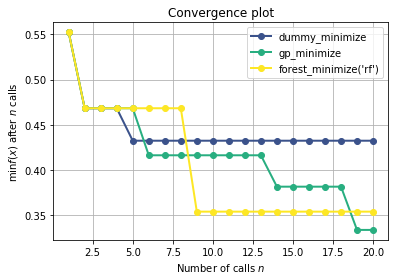

In [76]:
plot = plot_convergence(("dummy_minimize", results['dummy']),
                        ("gp_minimize", results['gp']),
                        ("forest_minimize('rf')", results['rf']),
#                         ("grad. boost reg. tree", results['gbrt2']),
                        )

In [44]:
plot = plot_convergence(
                        ("gp_minimize", gp_res),
                        ("forest_minimize('rf')", rf_res),
                        ("grad. boost reg. tree", gbrt_res),
                        )

NameError: name 'gp_res' is not defined

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69eb10e860>,
      dtype=object)

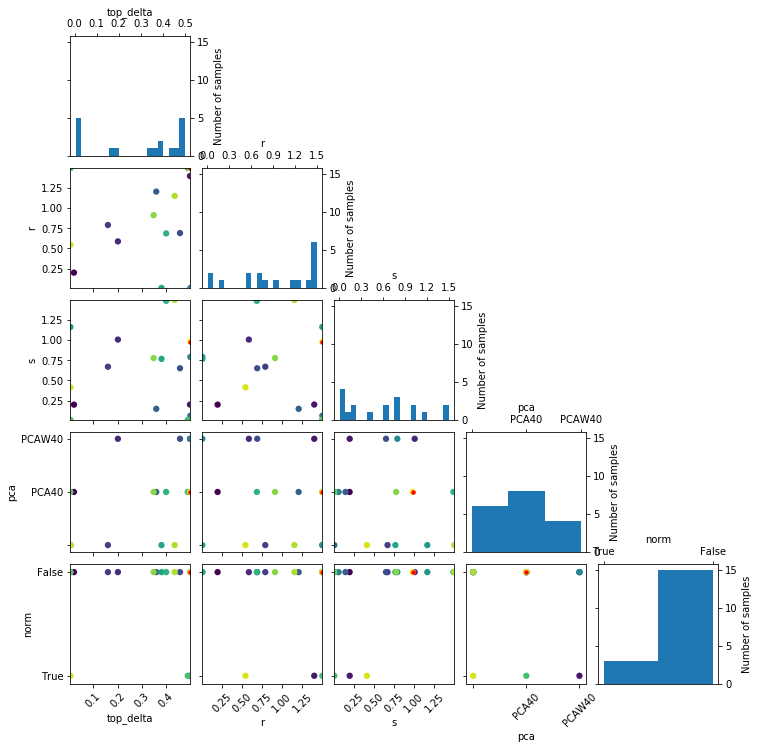

In [15]:
plot_evaluations(res)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f591e5ac3c8>,
      dtype=object)

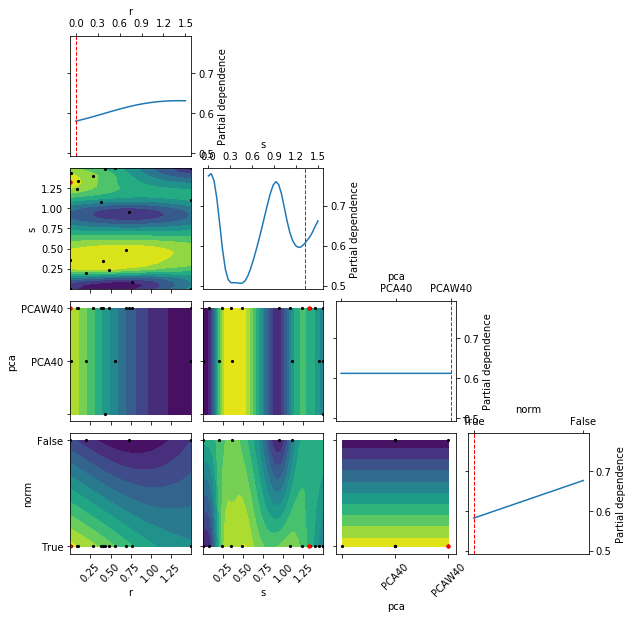

In [78]:
plot_objective(results['gp'], sample_source='result')

In [77]:
plot_objective(gp_res)

AttributeError: 'list' object has no attribute 'space'

In [23]:
res.keys()

dict_keys(['x', 'fun', 'func_vals', 'x_iters', 'models', 'space', 'random_state', 'specs'])

In [73]:
[print(res.x, res.fun) for res in gbrt_res]

[0.11980129286324427, 0.002536660333745278, 'PCAW40', True] 0.3777
[0.1126966355119884, 0.024851488002858694, 'PCAW40', True] 0.3687
[0.005193716452164877, 0.40035020458546866, '', True] 0.3165


[None, None, None]

In [16]:
res.x, res.fun

([0.005, 0.01, 0.01, '', True], 0.3191)

## the optimizer object

In [68]:
'T' in space_def = ['T', 'dx' ]

SyntaxError: can't assign to comparison (<ipython-input-68-1360d22a5f3e>, line 1)

In [69]:
'T' in space_def

True

In [80]:
SPACE = SPACE_ZR

[x for x in SPACE if x.name in space_def ]

[Real(low=0.2, high=0.7, prior='uniform', transform='identity'),
 Integer(low=3, high=30, prior='uniform', transform='identity')]

In [81]:
space_def

['T', 'dx']

In [46]:
SPACE_ZR = [
           skopt.space.Real(0.2, 0.7, name='T', prior='uniform'),
           skopt.space.Real(0.2, 0.7, name='medthr', prior='uniform'),
           skopt.space.Integer(3, 30, name='dx',prior='uniform'),
           skopt.space.Integer(3, 40, name='D',prior='uniform'),
           skopt.space.Integer(3, 40, name='R',prior='uniform'),
           skopt.space.Real(0.5, 30.0, name='castthr',prior='uniform'),
        ]

SPACE_KNN = [ 
            skopt.space.Integer(20, 200, name='k', prior='uniform'),
            skopt.space.Real(0.001, 0.5, name='top_delta', prior='uniform'),
           skopt.space.Real(1e-6, 1.5, name='r',prior='uniform', transform='identity'),
           skopt.space.Real(1e-6, 1.5, name='s',prior='uniform', transform='identity'),
           skopt.space.Categorical(['','PCA40','PCAW40'], name='pca'),
           skopt.space.Categorical([True,False], name='norm', ),            
        ]


In [54]:



class TunerSkopt():
    def __init__(self, seq_names, feats_dict, params):
        
        self.chkpoint_root = '/home/korhan/Dropbox/tez/checkpoints/' + params['disc_method']
        self.seq_names = seq_names
        self.feats_dict = feats_dict
        
        self.params = params
        
        self.tune_name = join(self.chkpoint_root, 
                              '{}_{}_{}'.format(params['tune']['minimizer'], 
                                                params['CVset'], params['featype'] ))
        
        self.prepared = False
            

    def _set_callbacks(self, names=['saver', 'stopper', 'timer', 'verb']):
        os.makedirs(self.chkpoint_root, exist_ok=True)
                
        checkpoint_saver = CheckpointSaver(self.tune_name + '.pkl', compress=9, 
                                           store_objective=False)
        stopper = DeltaYStopper(self.params['tune']['stop_margin'], 
                                self.params['tune']['stopper_patience'])
        timer = TimerCallback()
        verb = VerboseCallback(n_total=1)

        callbacks = {'saver':checkpoint_saver, 'stopper': stopper, 
                     'timer': timer, 'verb': verb}
        
        self.callbacks = [callbacks[x] for x in names]

        
    def _space_setter(self, space_def=None):
        # selects the given keys from pre-defined space
        # space_def: list of strings, keys of which params to tune
        
        space_select = {'zr': SPACE_ZR, 'zr_cat': SPACE_ZR, 'knn': SPACE_KNN}
        
        if space_def is None:
            space_def = self.params['tune']['keys']
        
        SPACE_0 = space_select[self.params['disc_method']]        
        self.SPACE = [x for x in SPACE_0 if x.name in space_def]
        
        # default params
        self.x0 = [self.params['disc'][k] for k in space_def]
        
    
    def _load_checkpoint(self, tune_name=None):

        if tune_name is None:
            tune_name = self.tune_name
        
        res = skopt.load(tune_name + '.pkl')
        x0 = res.x_iters
        y0 = res.func_vals

        return x0, y0        

   

    def prepare(self, load_checkpoint=None, space_def=None):
        
        self._set_callbacks()
        
        self._space_setter(space_def)
        self.y0 = None
        
        if load_checkpoint is not None:
            if isinstance(load_checkpoint, str):
                self.x0, self.y0 = self._load_checkpoint(load_checkpoint)
            else:
                self.x0, self.y0 = self._load_checkpoint()
        
        
        minimizers = {'rf': forest_minimize, 'gp': gp_minimize, 'gbrt': gbrt_minimize}
        
        self.minimizer = minimizers[self.params['tune']['minimizer']]
        
        self.prepared = True

        
    def run(self, n_calls=20, random_state=42):
    
        if not self.prepared:
            self.prepare()

        @skopt.utils.use_named_args(self.SPACE)
        def objective(**space_params):

            self.params['disc'] = {**self.params['disc'], **space_params}
            print(' === Running for new space {} ==='.format(space_params))
#                                            [k,v for k,v in space_params.items()]) )

            tstart = time.time()

            if self.params['tune']['n_split'] > 1:
                scores = cv_experiment(self.seq_names, self.feats_dict, 
                                       self.params, nfold=self.params['tune']['n_split'])
            else:
                scores = try_run_exp(self.feats_dict, self.params, genname=True)

            telapsed = time.time() - tstart
            print(' === Experiment completed in {}m {:.1f}seconds ==='.format(
                                           int(telapsed//60), telapsed%60 ))

            if not isinstance(scores, dict): 
                return 1.
            else:
                return scores['ned']
        
        self.result = self.minimizer(objective, self.SPACE, n_calls=n_calls, 
                                x0=self.x0, y0=self.y0, 
                                random_state=random_state, 
                                callback=self.callbacks)
        
        return self.result.x, self.result.fun
    
    
    def _plot(self, names=['scores', 'evals', 'partial']):
        
        if 'scores' in names:
            plt.plot(self.result.func_vals)
        if 'evals' in names:
            plot_evaluations(self.result)
        if 'partial' in names:
            plot_objective(self.result)


In [55]:
params['tune'] = dict()
params['tune']['keys'] = ['r', 's']
params['tune']['minimizer'] = 'gp'
params['tune']['n_split'] = 1
params['tune']['stop_margin'] = 0.01
params['tune']['stopper_patience'] = 5


tuner = TunerSkopt(seq_names, feats_dict, params)

In [56]:
tuner.prepare()
tuner._set_callbacks(['stopper'])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 started. Searching for the next optimal point.


In [57]:
tuner.run(n_calls=15)

 === Running for new space {'r': 0.09543457135303371, 's': 0.12203809662832513} ===
knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k100_lmax28_lmin4_metricL2_olapthr_m0.25_pcaPCA40_r0.09543457135303371_s0.12203809662832513_seg_typeuniform_normFalse_top_delta0.02_use_gpuTrue
0.06060606060606061
*** Matches already discovered !!! ***
*** found 118471 matches ***
*** post disc completed, found 9966 segments from 4983 clusters ***
*** Coverage: 0.0713, NED: 0.50
trial 0 th:0.06061 cov:0.07130 err:-0.02870
0.06800119002082537
*** Matches already discovered !!! ***
*** found 118471 matches ***
*** post disc completed, found 10996 segments from 5498 clusters ***
*** Coverage: 0.0768, NED: 0.50
trial 1 th:0.06800 cov:0.07680 err:-0.02320
0.0914773644902423
*** Matches already discovered !!! ***
*** found 118471 matches ***
*** post disc completed, found 14310 segments from 7155 clusters ***
*** Coverage: 0.0933, NED: 0.52
trial 2 th:0.09148 cov:0.09330 err:-0.00670
 === Experiment completed 

KeyboardInterrupt: 

In [58]:
params

{'CVroot': '/home/korhan/Dropbox/CVfolds',
 'CVset': 'A',
 'clustering': {'cost_thr': 0.06060606060606061,
  'method': 'pairwise',
  'olapthr_m': 0.25},
 'config_file': '/home/korhan/Dropbox/config/config_phoenix.json',
 'covth': 0.1,
 'dataset': 'phoenix',
 'disc': {'a': 4,
  'dim_fix': 10,
  'emb_type': 'gauss_kernel',
  'k': 100,
  'lmax': 28,
  'lmin': 4,
  'metric': 'L2',
  'olapthr_m': 0.25,
  'pca': 'PCA40',
  'r': 1.4883173467252673,
  's': 0.9262226469600654,
  'seg_type': 'uniform',
  'norm': False,
  'top_delta': 0.02,
  'use_gpu': True},
 'disc_method': 'knn',
 'exp_root': '/home/korhan/Desktop/tez/knn_exps/',
 'feats_root': '/home/korhan/Desktop/tez/dataset/features/',
 'featype': 'c3_right',
 'lr': 0.8,
 'njobs': 2,
 'patience': 30,
 'tune': {'keys': ['r', 's'],
  'minimizer': 'gp',
  'n_split': 1,
  'stop_margin': 0.01,
  'stopper_patience': 5},
 'basename': 'knn_A_c3_right',
 'expname': 'knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k100_lmax28_lmin4_metricL2_olapthr

In [28]:
tuner.callbacks

In [36]:
tuner.result

          fun: 0.4809
    func_vals: array([0.6572, 0.6581, 0.6572, 0.6414, 0.649 , 0.5851, 0.5672, 0.654 ,
       0.6545, 0.655 , 0.5404, 0.4927, 1.    , 0.4809, 0.5222])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=1608637542), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=1608637542), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_sc

In [43]:
tuner.result.specs

{'args': {'model_queue_size': None,
  'n_jobs': 1,
  'kappa': 1.96,
  'xi': 0.01,
  'n_restarts_optimizer': 5,
  'n_points': 10000,
  'callback': [<skopt.callbacks.CheckpointSaver at 0x7fd71761bb00>,
  'verbose': False,
  'random_state': <mtrand.RandomState at 0x7fd793620bd0>,
  'y0': None,
  'x0': [1.559382000545539, 1.1937003158929742],
  'acq_optimizer': 'auto',
  'acq_func': 'gp_hedge',
  'n_random_starts': 10,
  'n_calls': 15,
  'base_estimator': GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                           kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5),
                           n_restarts_optimizer=2, noise='gaussian',
                           normalize_y=True, optimizer='fmin_l_bfgs_b',
                           random_state=1608637542),
  'dimensions': Space([Real(low=0.0, high=2, prior='uniform', transform='normalize'),
         Real(low=0.0, high=2, prior='uniform', transform='normalize')]),
  'func': <function __main__.TunerSkopt.run.<locals>.ob

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd74f82c198>,
      dtype=object)

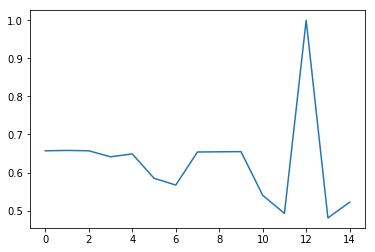

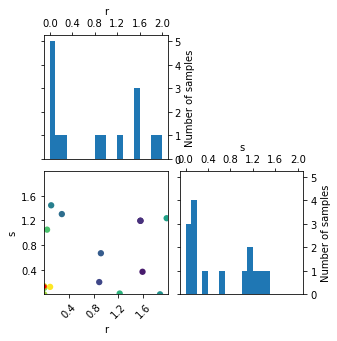

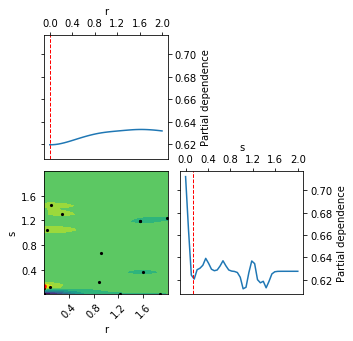

In [50]:
plt.plot(tuner.result.func_vals)
plot_evaluations(tuner.result)
plot_objective(tuner.result)